In [1]:
import sacpy as scp
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import sacpy.Map

In [2]:
time1 = "1980-01"
time2 = "2018-12"
data_path = "../../DATA/ncep2_180x90/"

uw = xr.open_dataset(data_path + "uwnd.10m.mon.mean.nc")['uwnd']
vw = xr.open_dataset(data_path + "vwnd.10m.mon.mean.nc")['vwnd']
get_sp = lambda data: data.loc[{"lon": slice(120, 280), "lat": slice(-30, 30), "time": slice(time1, time2)}]
uw, vw= map(get_sp, [uw, vw])
uwm, vwm= map(lambda data: data.groupby("time.month").mean(), [uw, vw])

In [3]:
month_ls = [[1,2,3],[7,8,9]]
wind_dict = {}
for idx in [0,1]:
    month = month_ls[idx]
    uwm1, vwm1 = map(lambda data: data[data.month.isin(month)].mean(axis=0),[uwm, vwm])
    wind_dict[idx] = [uwm1, vwm1]


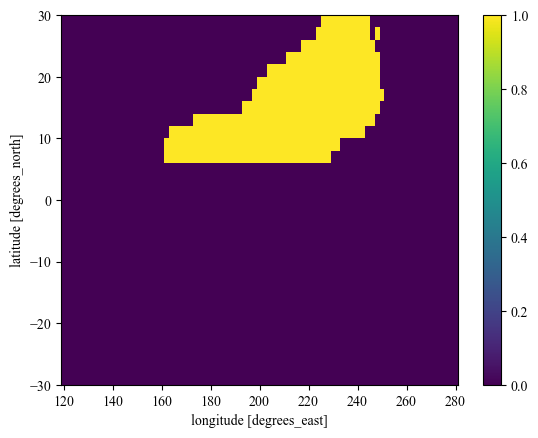

In [5]:
time1 = "1980-01"
time2 = "2018-12"
sst_loc = "../../DATA/HadISST_sst_2x2.nc"
sst = xr.open_dataset(sst_loc)['sst'].loc[time1:time2, -60:60]
ssta = scp.get_anom(sst)
ssta_eof = ssta.loc[:, -20:30, 150:275]
eof = scp.EOF(np.array(ssta_eof))
eof.solve()
pc = eof.get_pc(npt=3)
pt = eof.get_pt(npt=3)
sst_pt = ssta.loc[:, -30:30, 120:280]
ssta_lr = scp.LinReg(pc[1], sst_pt)
pmm_region_xr = -ssta_lr.slope
pmm_region_xr = pmm_region_xr > 0.17
pmm_region_xr[pmm_region_xr.lat <= 5] = False
# pmm_region_xr[pmm_region_xr.lat==29] = False
# ssta_lr.slope.splot()
# pmm_region_xr.plot()
pmm_region_xr1 = -ssta_lr.slope
pmm_region_xr1 = pmm_region_xr > 0.17
pmm_region_xr1[pmm_region_xr1.lat <= 5] = False
# pmm_region_xr[pmm_region_xr.lat==29] = False
# ssta_lr.slope.splot()
pmm_region_xr1.plot()
pmm_region = pmm_region_xr1

6.5401073
4.303016


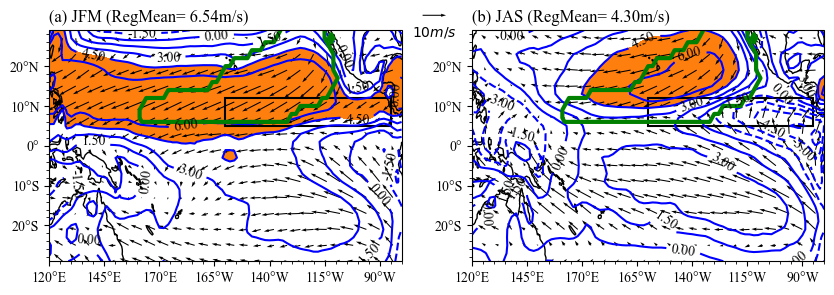

In [10]:
import matplotlib.patches as mpathes

fig = plt.figure(figsize=[10, 3])
title = ["JFM", "JAS"]
xPara = [200, 200, 275, 275]
yPara = [5, 12, 12, 5]
abcd = "abcd"
for i in range(2):
    ax = fig.add_subplot(1, 2, i + 1, projection=ccrs.PlateCarree(central_longitude=180))
    northeast_wind = -(wind_dict[i][1][0] + wind_dict[i][0][0]) / np.sqrt(2)
    ax.contourf(uw.lon, uw.lat, northeast_wind, levels=[4.5, 100], colors=["C1"], transform=ccrs.PlateCarree())
    regmean = northeast_wind.to_numpy()[pmm_region.to_numpy()].mean()
    print(regmean)
    q = ax.squiver(uw.lon, uw.lat, wind_dict[i][0][0], wind_dict[i][1][0], stepx=3, stepy=2, scale=150)
    ax.init_map()
    ax.set_title("({}) {} (RegMean= {:.2f}m/s)".format(abcd[i], title[i], regmean), loc="left")
    n = ax.scontour(uw.lon, uw.lat, northeast_wind, colors="blue", levels=np.arange(-6, 7, 1.5))
    ax.clabel(n, fmt="%.2f", colors="black")
    ax.scontour(pmm_region.lon, pmm_region.lat, pmm_region, levels=[0.5], colors="green", linewidths=3)
    ax.add_patch(
        mpathes.Polygon(xy=list(zip(xPara, yPara)),
                        fill=False,
                        color="black",
                        linewidth=1.5,
                        transform=ccrs.PlateCarree()))
ax.quiverkey(q, 0.51, 0.93, 10, r'$10 {m}/{s}$', labelpos='S', coordinates='figure')
plt.savefig("./pic/Fig4.png", dpi=300)
